# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call), sum(data[data.race=='b'].call)

(235.0, 157.0)

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


<div class="span5 alert alert-success">
<p>Your answers to Q1 and Q2 here</p>
</div>

We are trying to compare two proportions associated with two categorical variable, so a two proportion z-test would be useful. Furthur, we check the condition for performing z-test:

* The sampling method for each population is simple random sampling.

Yes, because black sounding and white sounding names are randomly assigned.

* The samples are independent.

We can assume that whether employer decide to callback on one resume is independent of another.

* Each sample includes at least 10 successes and 10 failures.

We see there are more than 10 callback and non-callback cases for both black and white group.

* Each population is at least 20 times as big as its sample.

The real black or white population in job market is much larger than this sample.

In [5]:
print('call back rate:')
print(data.groupby('race')['call'].mean())
data.groupby('race')['call'].value_counts()

call back rate:
race
b    0.064476
w    0.096509
Name: call, dtype: float32


race  call
b     0.0     2278
      1.0      157
w     0.0     2200
      1.0      235
Name: call, dtype: int64

We see that in this sample, although the other part of the resume are the same, the callback rate for white people (0.0965) is larger than that for black people (0.0645), so we suspect that there is a racial discrimination in the hiring procedure. Our hyphothese would be:

$H_0$: There is no racial discrimination. Employers treat black and white people equally, and callback rate does not depend on whether the name on resume looks like white people or black people, i.e. $p_w = p_b$.

$H_a$: There is a significant racial discrimination, that resume with white people names is has higher callback rate, i.e. $p_w > p_b$.

<div class="span5 alert alert-success">
<p> Your answers to Q3 here </p>
</div>

#### Use z-test for comparing two propartions

The p-value ~= 0.00002 is very small, so we should reject the null hyphothese and conclude that there is a racial discrimination. Consistently, the 99% interval does not contain 0, and we estimate that in 99% of samples, the callback rate for white people is larger than that for black people by 0.012 - 0.05. If we use the rate difference of this sample as an estimate, our marginal error would be 0.02.

In [6]:
pw = data['call'].loc[data['race']=='w'].mean()
pb = data['call'].loc[data['race']=='b'].mean()
p = data['call'].mean()
nw = sum(data['race']=='w')
nb = sum(data['race']=='b')
SE = np.sqrt(p*(1-p)*(1.0/nw+1.0/nb))
z = (pw-pb)/SE
p_value = 1 - stats.norm.cdf(z)
print("test statistic: z=%.4f, p-value: %.8f" %(z, p_value))

zl, zh = stats.norm.ppf((0.005,0.995))
ci = (pw-pb+zl*SE, pw-pb-zl*SE)
me = (ci[1]-ci[0])/2
print("99% confidence interval:",ci)
print("marginal error: %.6f"%me)

test statistic: z=4.1084, p-value: 0.00001992
99% confidence interval: (0.011949386296142485, 0.05211632341397867)
marginal error: 0.020083


#### Bootstrap Simulation

The bootstrap simulation can be down by randomly permuting all 'callback' values, then assign the first $n_w$ as white samples and last $n_b$ as black samples. With 100000 bootstrap samples, we can find the p-value being the ratio that the callback rate in white samples is at least $p_w - p_b$ higher than the callback rate in black samples.

We find bootstrap simulation gives similar results for p-value, confidence interval and marginal error as in two-sample z-test for proportions.

In [7]:
def draw_bs_rep(x, size=1):
    bs_pw = np.empty(size)
    bs_pb = np.empty(size)
    for i in range(size):
        bs_sample = np.random.permutation(x)
        bs_w = bs_sample[:nw]
        bs_b = bs_sample[-nb:]
        bs_pw[i] = bs_w.mean()
        bs_pb[i] = bs_b.mean()
    return bs_pw, bs_pb

bs_pw, bs_pb = draw_bs_rep(data['call'].values, 100000)
bs_p_value = np.sum(bs_pw-bs_pb > pw-pb)/len(bs_pw)
print("bootstrap p-value %.6f"%bs_p_value)

ci = np.percentile(bs_pw-bs_pb, [0.5,99.5]) + pw-pb
me = (ci[1]-ci[0])/2
print("99% confidence interval:",ci)
print("marginal error: %.6f"%me)

bootstrap p-value 0.000020
99% confidence interval: [0.01232032 0.05174538]
marginal error: 0.019713


<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>

The above analysis indicates that race is a significant factor in determining the callback rate. However, there may be other variables that have stronger influence on callback rate. For example, we can check the correlation between callback rate and other numerical variables provided in the data:

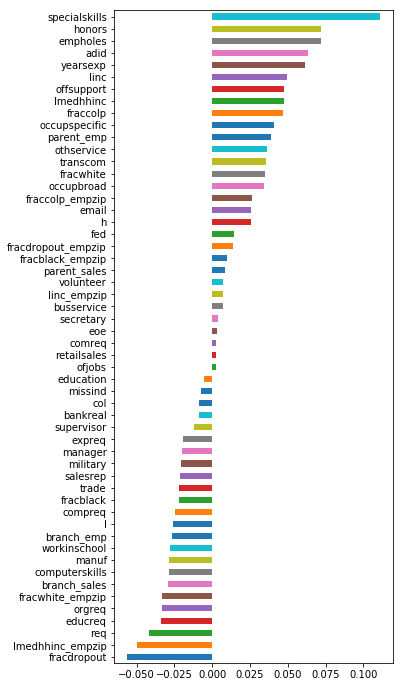

In [8]:
corr = pd.Series()
for col in data.columns.values[1:]:
    if data[col].dtype == 'O':
        continue
    if col == 'call':
        continue
    corr[col] = data[col].corr(data['call'])

plt.figure(figsize=(5,12))
corr = corr.sort_values()
corr.plot.barh()
plt.show()

We see there are other variables strongly correlated with callback rate (either positively or negatively). 